# Intro to Machine Learning

In [ ]:
!pip install statsmodels

In [1]:
import os
import umap

from zipfile import ZipFile

from sklearn.datasets import load_breast_cancer
from sklearn.datasets import fetch_openml

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC as BlackBoxClassifier
from sklearn.cluster import DBSCAN as BlackBoxClustering
from sklearn.cluster import AgglomerativeClustering as BlackBoxClustering2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import statsmodels.api as sm
BlackBoxForecasting = sm.tsa.statespace.SARIMAX

import matplotlib.pyplot as plt
from pylab import rcParams

import pandas as pd
import numpy as np
import seaborn as sns

np.set_printoptions(precision=2)

os.environ["KAGGLE_USERNAME"] = "injeans"
os.environ["KAGGLE_KEY"] = "cc08cc14836d12bd8bfccdfff9147ab7"

%matplotlib inline

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, ax=ax, cmap="YlGnBu")
    # We want to show all ticks...
    ax.set(xticks=[0.5, 1.5],
           yticks=[0.5, 1.5],
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

#     # Loop over data dimensions and create text annotations.
#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i in range(cm.shape[0]):
#         for j in range(cm.shape[1]):
#             ax.text(j, i, format(cm[i, j], fmt),
#                     ha="center", va="center",
#                     color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## What is ML?

<img src="assets/what_is_ml.png" alt="Drawing" style="width: 500px;"/>

A popular definition for machine learning, given by [Mitchell 1997](http://www.cs.cmu.edu/afs/cs.cmu.edu/user/mitchell/ftp/mlbook.html), is

> A computer program is said to learn from experience, E, with respect to some class of tasks, T, and performance measure, P, if its performance at tasks in T, as measured by P, improves with experience E.

## Experience

Typically, the experience a machine learning algorithm encounters during learning is in the form of a dataset, or exposure to a dataset (or subset thereof). A dataset is a collection of examples, each example comprising a set of features that have been quantitatively measured from some object or event. We typically represent an example as a vector $x \in \mathbb{R}^N$, where each entry  of the vector is another feature. Broadly speaking, experiences are often categorised as either **unsupervised** or **supervised**.

### Supervised

Supervised learning algorithms experience a dataset containing features, but each example is also associated with a **label** or **target**. Supervised learning involves observing several examples of random vector, $x$, and an associated value or vector $y$, then learning to predict $y$ from $x$, usually by estimating $p(y|x)$ [(Goodfellow, Bengio, & Courville, 2016)](#References). 

Let's take a look at an example of a supervised experience.

In [ ]:
breast_cancer_data = load_breast_cancer()
breast_cancer_df = pd.DataFrame(data=np.c_[breast_cancer_data['data'], breast_cancer_data['target']],
                                columns=breast_cancer_data['feature_names'].tolist() + ['target'])
breast_cancer_df.head()

In [ ]:
breast_cancer_df.describe()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

sns.distplot(breast_cancer_df['target'], ax=axes[0])

trans = umap.UMAP(n_neighbors=5, random_state=42).fit(breast_cancer_data['data'])

axes[1].scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], 
                s=50, c=breast_cancer_data['target'], cmap='Spectral')
           
fig.tight_layout()

In [ ]:
sns.heatmap(breast_cancer_df.corr())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(breast_cancer_data['data'], breast_cancer_data['target'], 
                                                    test_size=0.2, random_state=41)

clf = BlackBoxClassifier(gamma="scale")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Classification accuracy: {:.2f}%".format(accuracy_score(y_pred, y_test)*100))

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=breast_cancer_data['target_names'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### (Self?/) Unsupervised

Unsupervised learning algorithms experience a datset containing many features, then learn useful properties of the structure of this dataset. Unsupervised learning involves observing several examples of a random vector, $x$, and attempting to implicitly or explicitly learn the probability distribution $p(x)$, or some interesting properties of that distribution [(Goodfellow, Bengio, & Courville, 2016)](#References).

Let's dive in!

In [ ]:
higgs_data = fetch_openml(name='higgs')
higgs_df = pd.DataFrame(data=np.c_[higgs_data['data'], higgs_data['target']],
                               columns=higgs_data['feature_names'] + ['target'])
higgs_df.dropna(inplace=True)
higgs_df = higgs_df[higgs_df["target"]==1]
higgs_df = higgs_df.sample(frac=0.2, random_state=42)
higgs_df.head()

In [ ]:
higgs_df.describe()

In [ ]:
trans = umap.UMAP(n_neighbors=5, random_state=42).fit(higgs_df.drop('target', axis=1).values)

plt.figure(figsize=(20,10))
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s=50)

In [ ]:
clst = BlackBoxClustering(eps=4, min_samples=3)
clst.fit(higgs_df.drop('target', axis=1).values)
y_pred = clst.labels_

print(np.unique(y_pred))

plt.figure(figsize=(20,10))
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], 
            s=50, c=y_pred, cmap='Spectral')
plt.colorbar()

## Task

Many kinds of tasks can be solved with machine learning. Some of the most common machine learning tasks include the following:

- **Classiﬁcation**: the computer program is asked to specify which of $k$ categories some input belongs to. To solve this task, the learning algorithm is usually asked to produce a function $f:\mathbb{R}^n \to \{1, \dots, k\}$. When $y=f(\mathbf{x})$, the model assigns an input described by vector $\mathbf{x}$ to a category identiﬁed by numeric code $y$. There are other variants of the classiﬁcation task, for example, where $f$ outputs a probability distribution over classes. An example of a classiﬁcation task is object recognition, where the input is an image (usually described as a set of pixel brightness values), and the output is a numeric code identifying the object in the image.
- **Regression**: the computer program is asked to predict a numerical value given some input. To solve this task, the learning algorithm is asked to output a function $f:\mathbb{R}^n\to \mathbb{R}$. This type of task is similar to classiﬁcation, except that the format of output is diﬀerent. An example of a regression task is the prediction of the expected claim amount that an insured person will make (used to set insurance premiums), or the prediction of future prices of securities. These kinds of predictions are also used for algorithmic trading.
- **Clustering**: the assignment of a set of observations into subsets (called clusters) so that observations in the same cluster are similar in some sense.

Okay so let's consider these tasks in the context of a new dataset.

In [3]:
!kaggle datasets download -d cityofLA/los-angeles-traffic-collision-data -p kaggle_data
with ZipFile('kaggle_data/los-angeles-traffic-collision-data.zip', 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall('kaggle_data')
!ls kaggle_data

los-angeles-traffic-collision-data.zip: Skipping, found more recently modified local copy (use --force to force download)
los-angeles-traffic-collision-data.zip
socrata_metadata.json
traffic-collision-data-from-2010-to-present.csv


In [4]:
la_df = pd.read_csv("kaggle_data/traffic-collision-data-from-2010-to-present.csv")
la_df['Date Reported'] = pd.to_datetime(la_df['Date Reported'])
la_df['Date Occurred'] = pd.to_datetime(la_df['Date Occurred'])
la_df.drop(labels="DR Number", axis=1, inplace=True)
la_df.drop(labels="Crime Code Description", axis=1, inplace=True)
la_df.dropna(inplace=True)
la_df.head()

,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,MO Codes,Victim Age,Victim Sex,...,Premise Description,Address,Cross Street,Location,Zip Codes,Census Tracts,Precinct Boundaries,LA Specific Plans,Council Districts,Neighborhood Councils (Certified)
31,2019-09-13,2019-09-13,1859,18,Southeast,1842,997,0605,54.0,M,...,STREET,IMPERIAL HY,BROADWAY,"{'longitude': '-118.2783', 'latitude': '33.931...",24355.0,809.0,1194.0,7.0,14.0,53.0
35,2019-09-14,2019-09-13,2315,18,Southeast,1846,997,0605,25.0,M,...,STREET,CENTRAL,112TH ST,"{'longitude': '-118.2542', 'latitude': '33.933...",24354.0,821.0,1193.0,7.0,15.0,40.0
42,2019-09-13,2019-09-13,1800,12,77th Street,1249,997,0605,68.0,M,...,STREET,GAGE AV,FIGUEROA ST,"{'longitude': '-118.2827', 'latitude': '33.982...",23675.0,767.0,991.0,7.0,13.0,2.0
45,2019-09-14,2019-09-13,1440,13,Newton,1383,997,1300,43.0,F,...,STREET,BROADWAY,59TH ST,"{'longitude': '-118.2783', 'latitude': '33.986...",22352.0,785.0,993.0,7.0,13.0,46.0
51,2019-09-13,2019-09-13,1445,3,Southwest,353,997,4025 3036 3008 3026 3029 3104,16.0,M,...,STREET,RODEO,CRENSHAW,"{'longitude': '-118.3354', 'latitude': '34.019...",23077.0,663.0,1007.0,7.0,12.0,17.0


In [5]:
la_df.describe()

,Time Occurred,Area ID,Reporting District,Crime Code,Victim Age,Premise Code,Zip Codes,Census Tracts,Precinct Boundaries,LA Specific Plans,Council Districts,Neighborhood Councils (Certified)
count,107352.000000,107352.000000,107352.000000,107352.0,107352.000000,107352.000000,107352.000000,107352.000000,107352.000000,107352.000000,107352.000000,107352.000000
mean,1384.606966,11.154659,1164.880142,997.0,41.416136,101.883998,21852.813324,711.409140,954.362313,10.177668,10.512566,42.099607
std,574.236722,5.404875,537.890328,0.0,16.105503,16.077612,4793.293885,332.123682,307.724068,8.425495,3.674953,24.560838
min,1.000000,1.000000,109.000000,997.0,10.000000,101.000000,3221.000000,1.000000,27.000000,1.000000,1.000000,1.000000
25%,1000.000000,8.000000,833.000000,997.0,28.000000,101.000000,22721.000000,579.000000,745.000000,7.000000,8.000000,24.000000
50%,1445.000000,12.000000,1253.000000,997.0,39.000000,101.000000,23443.000000,748.000000,993.000000,7.000000,12.000000,43.000000
75%,1825.000000,14.000000,1487.000000,997.0,52.000000,101.000000,23678.000000,821.000000,1174.000000,10.000000,14.000000,57.000000
max,2359.000000,21.000000,2199.000000,997.0,99.000000,726.000000,25714.000000,2342.000000,1558.000000,54.000000,15.000000,95.000000


### Classification

In [8]:
from sklearn.preprocessing import KBinsDiscretizer

target = la_df['Victim Age']

est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
binned_target = est.fit_transform(target.values.reshape(-1,1))

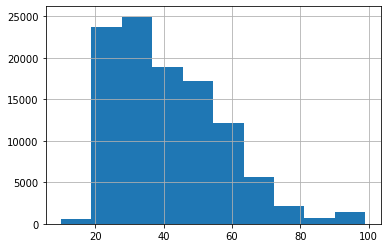

In [9]:
target.hist()

In [10]:
binned_target

array([[2.],
       [0.],
       [3.],
       ...,
       [0.],
       [2.],
       [2.]])

In [16]:
ageless_df = la_df.drop("Victim Age", axis=1)
ageless_df["Date Reported"] = lb_make.fit_transform(ageless_df["Date Reported"])
ageless_df["Date Occurred"] = lb_make.fit_transform(ageless_df["Date Occurred"])

obj_df = ageless_df.select_dtypes(include=['object']).copy()

for col in obj_df.columns:
    ageless_df[col] = lb_make.fit_transform(ageless_df[col])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(ageless_df, binned_target, 
                                                    test_size=0.2, random_state=41)

clf = BlackBoxClassifier(gamma="scale")
clf.fit(X_train[:1000], y_train[:1000])
y_pred = clf.predict(X_test[:1000])

print("Classification accuracy: {:.2f}%".format(accuracy_score(y_pred, y_test[:1000])*100))

In [11]:
single_mo_df = la_df[la_df['MO Codes'].str.split().str.len().lt(2)]
gb_df = single_mo_df.groupby("MO Codes").count()['Date Reported']
mo_codes = gb_df[gb_df.gt(100)].index
clf_df = la_df[la_df['MO Codes'].isin(mo_codes)].copy()

target = clf_df.pop('MO Codes')
features_df = clf_df.drop("Location", axis=1)

In [12]:
la_df.dtypes

Date Reported                        datetime64[ns]
Date Occurred                        datetime64[ns]
Time Occurred                                 int64
Area ID                                       int64
Area Name                                    object
Reporting District                            int64
Crime Code                                    int64
MO Codes                                     object
Victim Age                                  float64
Victim Sex                                   object
Victim Descent                               object
Premise Code                                float64
Premise Description                          object
Address                                      object
Cross Street                                 object
Location                                     object
Zip Codes                                   float64
Census Tracts                               float64
Precinct Boundaries                         float64
LA Specific 

In [13]:
lb_make = LabelEncoder()
features_df["Date Reported"] = lb_make.fit_transform(features_df["Date Reported"])
features_df["Date Occurred"] = lb_make.fit_transform(features_df["Date Occurred"])
obj_df = features_df.select_dtypes(include=['object']).copy()

for col in obj_df.columns:
    features_df[col] = lb_make.fit_transform(features_df[col])

target = lb_make.fit_transform(target)
features_df.head()

,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Victim Age,Victim Sex,Victim Descent,Premise Code,Premise Description,Address,Cross Street,Zip Codes,Census Tracts,Precinct Boundaries,LA Specific Plans,Council Districts,Neighborhood Councils (Certified)
31,1851,1865,1859,18,14,1842,997,54.0,1,1,101.0,10,601,386,24355.0,809.0,1194.0,7.0,14.0,53.0
35,1852,1865,2315,18,14,1846,997,25.0,1,1,101.0,10,378,20,24354.0,821.0,1193.0,7.0,15.0,40.0
42,1851,1865,1800,12,0,1249,997,68.0,1,13,101.0,10,523,651,23675.0,767.0,991.0,7.0,13.0,2.0
45,1852,1865,1440,13,9,1383,997,43.0,0,1,101.0,10,331,159,22352.0,785.0,993.0,7.0,13.0,46.0
60,1851,1865,910,18,14,1803,997,18.0,0,5,101.0,10,211,896,22352.0,798.0,1175.0,7.0,13.0,45.0


In [ ]:
features_df.dtypes

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_df.values, target, 
                                                    test_size=0.2, random_state=42)

clf = BlackBoxClassifier(gamma="scale")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Classification accuracy: {:.2f}%".format(accuracy_score(y_pred, y_test)*100))

### Regression

In [ ]:
collisions = la_df.groupby(['Date Occurred'])["Date Reported"].count().reset_index()
collisions = collisions.set_index('Date Occurred')
collisions

In [ ]:
y = collisions['Date Reported'].resample('MS').mean()

In [ ]:
y.plot(figsize=(15, 6))

In [ ]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
fcst = BlackBoxForecasting(y,
                           order=(0, 1, 1),
                           seasonal_order=(0, 1, 1, 12),
                           enforce_stationarity=False,
                           enforce_invertibility=False)
results = fcst.fit()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('# Collisions')
plt.legend()
plt.show()

### Clustering

In [ ]:
trans = umap.UMAP(n_neighbors=5, random_state=42).fit(X_train)

plt.figure(figsize=(20,10))
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s=50)

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s=50, c=y_train, cmap='Spectral')

In [ ]:
clst = BlackBoxClustering2()
clst.fit(X_train)
y_pred = clst.labels_

print(np.unique(y_pred))

plt.figure(figsize=(20,10))
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], 
            s=50, c=y_pred, cmap='Spectral')
plt.colorbar()

### References

[Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press. Retrieved from https://www.deeplearningbook.org](https://www.deeplearningbook.org)